## Importing libraries

In [39]:
import os
import sys
import numpy as np
import pandas as pd
import time
from datetime import date, timedelta, datetime
import pandas_gbq
from google.cloud import bigquery
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import math

from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
import gc
from alibi.explainers import ALE, plot_ale
warnings.filterwarnings('ignore')
collected_objects = gc.collect()

In [2]:
os.environ["http_proxy"] = "http://geoproxy.kohls.com:3128"
os.environ["HTTP_PROXY"] = "http://geoproxy.kohls.com:3128"
os.environ["https_proxy"] = "http://geoproxy.kohls.com:3128"
os.environ["HTTPS_PROXY"] = "http://geoproxy.kohls.com:3128"

client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

del os.environ['http_proxy']
del os.environ['HTTP_PROXY']
del os.environ['https_proxy']
del os.environ['HTTPS_PROXY']

os.chdir('/home/jupyter/SalesForecasting/GmWorkingData/Unsubscribe_email')

Client creating using default project: kohls-bda-mkt-lle


## Important functions

In [3]:
def customize_split(number):
    """
    Input
    number: int
    Output
    grp_num: Provides grp_num to which numbers belong between customize percentile [1,3,5,10,20,100].
    """
    if number == 1:
        grp_num = 1
    elif number <=3:
        grp_num = 3
    elif number <=5:
        grp_num = 5
    elif number <=10:
        grp_num = 10
    elif number <=20:
        grp_num = 20
    elif number <=100:
        grp_num = 100
    return grp_num

In [4]:
def calc_lorenze_acc(X:pd.DataFrame(), y:pd.DataFrame(), actual:str, pred_value:str, m, method='gini', num_split=100, cust_split_list = [1,3,5,10,20,100]):
    """
    X : dataframe of testing data
    y : dataframe of target data
    actual : Target col name
    pred_value : prediction col name
    m : trained model name
    method : default to gini
    num_split : number for splitting the data into buckets.
    cust_split_list : customize splitting list.
    If changing the customized percentage list then change the customize_split function accordingly.
    """
    
    df=pd.DataFrame(y.copy())
    df[pred_value]= m.predict_proba(X)[:,1]
    data = df.copy()
    data = data.sort_values(pred_value, ascending=False)
    data['rank'] = range(len(data))
    data['perc_grp'] =data['rank'].apply(lambda x: (math.floor(num_split * x/len(y))+1))
    data['grp'] = data['perc_grp'].apply(lambda x : customize_split(x))

    lorenz = data.groupby('grp')[[pred_value, actual]].mean()
    lorenz['num_mail_id']=data.groupby('grp').size()
    lorenz['actual_not_unsubscribed']=data.groupby('grp')[[actual]].agg(lambda x: x.eq(0).sum())
    lorenz['actual_unsubscribed']=data.groupby('grp')[[actual]].agg(lambda x: x.eq(1).sum())
    lorenz["per_unsubscribed"] = lorenz['actual_unsubscribed']/lorenz['num_mail_id']

    cum_dict = {}
    cum_df = pd.DataFrame()
    for per in cust_split_list:
        temp_dict = {
            "grp" : per,
            "y_pred_xgbc_oot_cum" : data[data["perc_grp"]<=per][[pred_value, actual]].mean()[pred_value],
            "unsubscribe_or_not_cum" : data[data["perc_grp"]<=per][[pred_value, actual]].mean()[actual],
            "num_mail_id_cum" : data[data["perc_grp"]<=per].shape[0],
            "actual_not_unsubscribed_cum" : data[data["perc_grp"]<=per][data[data["perc_grp"]<=per][actual]==0].shape[0],
            "actual_unsubscribed_cum" : data[data["perc_grp"]<=per][data[data["perc_grp"]<=per][actual]==1].shape[0],
            "per_unsubscribed_cum" : data[data["perc_grp"]<=per][data[data["perc_grp"]<=per][actual]==1].shape[0]/data[data["perc_grp"]<=per].shape[0]
        }
        temp_df = pd.DataFrame([temp_dict])
        cum_df = pd.concat([cum_df,temp_df], ignore_index = True)
    cum_df.set_index("grp", drop = True)

    lorenz = pd.merge(lorenz,cum_df,on = "grp")
    total = data[actual].sum()
    y1 = data[[actual, pred_value]].sort_values(pred_value, ascending=False) [actual].cumsum().values/total
    y2 = data[[actual, pred_value]].sort_values(actual, ascending=False)[actual].cumsum().values/total
    x1 = ((2*y1.sum()-y1[-1])/df.shape[0])-1
    x2 = ((2*y2.sum()-y2[-1])/df.shape[0])-1
    gini=x1/x2
    
    return gini, lorenz, data

In [5]:
def model_testing(X_test_y,y_test_y,xgbc_y):
     
    y_pred_xgbc_y = xgbc_y.predict(X_test_y)
    
    print(f"Accuracy score : {accuracy_score(y_test_y,y_pred_xgbc_y)}, Precision score : {precision_score(y_test_y,y_pred_xgbc_y)}, Recall score : {recall_score(y_test_y,y_pred_xgbc_y)}, f1 score : {f1_score(y_test_y,y_pred_xgbc_y)}")
    print(f"Confusion matrix : {confusion_matrix(y_test_y,y_pred_xgbc_y)}")
    
    gini_oos_y, lorenz_oos_y, data_oos_y = calc_lorenze_acc(X_test_y, y_test_y, "unsubscribe_or_not", "y_pred_xgbc_y_oos", xgbc_y, method='gini', num_split=100, cust_split_list = [1,3,5,10,20,100])
    del y_pred_xgbc_y
    return gini_oos_y, lorenz_oos_y, data_oos_y

In [60]:
def ale_plots(X_train_y, feature_names, target_names, xgbc1_y, num_for_slicing=100000):
    
    # Set your working directory and use this path to store the results
    dir_str = "ale"
    if not os.path.exists(dir_str):
        os.makedirs(dir_str)
        print("Created Directory : ", dir_str,"\n")
    else:
        print("Directory already existed : ", dir_str,"\n")

    # ALEs for the validation dataset declaration    
    proba_fun_lr = xgbc1_y.predict_proba
    ale_eff = ALE(proba_fun_lr,
              feature_names = feature_names,
              target_names = target_names)
    
    # create index list for independent vars
    indep_index_li = []
    # create an empty dict
    grid_points = {}
    
    for indep in feature_names:
        indep_index_num = feature_names.index(indep)
        indep_index_li.append(indep_index_num)
        grid_points[indep_index_num] = np.unique(X_train_y.dropna()[:num_for_slicing].iloc[:,indep_index_num:indep_index_num+1].describe(percentiles=np.arange(0.05,0.95,0.05)).values[4:-1])
    
    xgb1_exp = ale_eff.explain(X_train_y.dropna()[:num_for_slicing].values,features=indep_index_li,grid_points=grid_points)
    

    # Store the ALE results now
    for i in range(0,len(feature_names)):
        
        z1 = pd.DataFrame(xgb1_exp.feature_values[i][1:-1],columns=[str(feature_names[i])])
        z2 = pd.DataFrame(xgb1_exp.ale_values[i][1:-1,1]+xgb1_exp.constant_value,columns=target_names)
        
    # Merge the feature values and corresponding ales
        z1_z2 = pd.merge(z1,z2,left_index=True,right_index=True).reset_index(drop=True)
        ale_df = z1_z2.copy().drop_duplicates()            
        ale_str = dir_str + "/" + "mid_ale_" + str(feature_names[i]) +".csv"
        ale_df.to_csv(ale_str,index=False)
    
    # Plotting ale curve
    plot_ale(xgb1_exp, features = feature_names, fig_kw = {'figwidth' : 10, 'figheight' : 10})
    plt.show()
    
    return xgb1_exp

## Data Ingestion

In [6]:
# TRAINING DATA
t1 = time.time()

qr1 = '''SELECT * FROM kohls-bda-mkt-prd.dp_marketing_sandbox.TKA1JB1_email_unsubscribe_yearly_data_r3_train_OOS_1'''
training_data = pandas_gbq.read_gbq(qr1,project_id='kohls-bda-mkt-lle',use_bqstorage_api=True)

print(f"Total time taken to read the data : {(time.time()-t1)/60} mins")

Downloading: 100%|██████████|
Total time taken to read the data : 4.689551583925883 mins


## Data Preparation

In [7]:
training_data.shape

(23830085, 78)

In [8]:
pd.set_option('display.max_columns', None)
training_data.head(2)

,email_addr,vantage_date,month_num,unsubscribe_or_not,ttl_num_of_cls_in_pst_mth,ttl_num_of_opens_in_pst_mth,ttl_num_of_mails_sent_in_pst_mth,ttl_num_of_cls_in_lst_90_days_bf_pst_mth,ttl_num_of_op_in_lst_90_days_bf_pst_mth,ttl_num_of_mails_snt_in_lst_90_days_bf_pst_mth,cust_id,ttl_opt_out_num,rec_opt_in_days,mail_cnt_asn_pr_cust,total_trip_cnt,months_to_last_trans,cust_age,med_incm,kc_holder,dist_to_store,lst_qrt_trp_cnt,lst_qrt_pur_qnts,lst_qrt_spt_amt,lst_qrt_dis_qnt,lst_qrt_dis_spt_amt,lst_qrt_pur_qnts_wt_kc_card,lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_lst_qrt,BEAUTY_trans_pur_amt_for_lst_qrt,CHILDRENS_trans_pur_amt_for_lst_qrt,HOME_trans_pur_amt_for_lst_qrt,MENS_trans_pur_amt_for_lst_qrt,WOMENS_trans_pur_amt_for_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_lst_qrt,sec_lst_qrt_trp_cnt,sec_lst_qrt_pur_qnts,sec_lst_qrt_spt_amt,sec_lst_qrt_dis_qnt,sec_lst_qrt_dis_spt_amt,sec_lst_qrt_pur_qnts_wt_kc_card,sec_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_sec_lst_qrt,BEAUTY_trans_pur_amt_for_sec_lst_qrt,CHILDRENS_trans_pur_amt_for_sec_lst_qrt,HOME_trans_pur_amt_for_sec_lst_qrt,MENS_trans_pur_amt_for_sec_lst_qrt,WOMENS_trans_pur_amt_for_sec_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_sec_lst_qrt,trd_lst_qrt_trp_cnt,trd_lst_qrt_pur_qnts,trd_lst_qrt_spt_amt,trd_lst_qrt_dis_qnt,trd_lst_qrt_dis_spt_amt,trd_lst_qrt_pur_qnts_wt_kc_card,trd_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_trd_lst_qrt,BEAUTY_trans_pur_amt_for_trd_lst_qrt,CHILDRENS_trans_pur_amt_for_trd_lst_qrt,HOME_trans_pur_amt_for_trd_lst_qrt,MENS_trans_pur_amt_for_trd_lst_qrt,WOMENS_trans_pur_amt_for_trd_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_trd_lst_qrt,frt_lst_qrt_trp_cnt,frt_lst_qrt_pur_qnts,frt_lst_qrt_spt_amt,frt_lst_qrt_dis_qnt,frt_lst_qrt_dis_spt_amt,frt_lst_qrt_pur_qnts_wt_kc_card,frt_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_frt_lst_qrt,BEAUTY_trans_pur_amt_for_frt_lst_qrt,CHILDRENS_trans_pur_amt_for_frt_lst_qrt,HOME_trans_pur_amt_for_frt_lst_qrt,MENS_trans_pur_amt_for_frt_lst_qrt,WOMENS_trans_pur_amt_for_frt_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_frt_lst_qrt,llty_ind,eml_supp_tst_grps
0,pUvfEc@scDZh.8PF,2022-07-01,7,0,0,0,32,0,0,105,67448183,3,908,1,26,10,43,52500,1,1.101828835,0,0,0E-9,0,0E-9,0,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,1,14,210.140000000,10,193.530000000,14,210.140000000,0E-9,0E-9,50.130000000,8.800000000,0E-9,21.660000000,0E-9,0,0,0E-9,0,0E-9,0,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,5,41,611.130000000,35,374.550000000,21,237.880000000,234.990000000,0E-9,192.460000000,0E-9,18.980000000,44.130000000,89.780000000,1,None
1,PCS6e5j@Mr2Ob.pWh,2022-10-01,10,0,0,51,50,0,144,143,1106379582,3,1000,2,128,2,56,125000,1,33.163125630,3,32,656.620000000,26,599.830000000,32,656.620000000,16.840000000,0E-9,0E-9,522.750000000,0E-9,21.600000000,0E-9,3,19,466.720000000,17,445.870000000,19,466.720000000,0E-9,0E-9,0E-9,271.970000000,0E-9,158.910000000,0E-9,6,50,684.120000000,48,647.560000000,50,684.120000000,112.810000000,0E-9,60.400000000,180.360000000,63.530000000,143.830000000,49.700000000,11,84,1212.410000000,74,1038.790000000,76,1065.420000000,171.270000000,0E-9,243.160000000,393.750000000,147.040000000,185.250000000,0E-9,1,None


In [9]:
col_to_convert_float_ls = ['dist_to_store',
'lst_qrt_spt_amt',
'lst_qrt_dis_spt_amt',
'lst_qrt_spt_amt_wt_kc_card',
'ACTIVE_trans_pur_amt_for_lst_qrt',
'BEAUTY_trans_pur_amt_for_lst_qrt',
'CHILDRENS_trans_pur_amt_for_lst_qrt',
'HOME_trans_pur_amt_for_lst_qrt',
'MENS_trans_pur_amt_for_lst_qrt',
'WOMENS_trans_pur_amt_for_lst_qrt',
'YOUNG_WOMENS_trans_pur_amt_for_lst_qrt',
'sec_lst_qrt_spt_amt',
'sec_lst_qrt_dis_spt_amt',
'sec_lst_qrt_spt_amt_wt_kc_card',
'ACTIVE_trans_pur_amt_for_sec_lst_qrt',
'BEAUTY_trans_pur_amt_for_sec_lst_qrt',
'CHILDRENS_trans_pur_amt_for_sec_lst_qrt',
'HOME_trans_pur_amt_for_sec_lst_qrt',
'MENS_trans_pur_amt_for_sec_lst_qrt',
'WOMENS_trans_pur_amt_for_sec_lst_qrt',
'YOUNG_WOMENS_trans_pur_amt_for_sec_lst_qrt',
'trd_lst_qrt_spt_amt',
'trd_lst_qrt_dis_spt_amt',
'trd_lst_qrt_spt_amt_wt_kc_card',
'ACTIVE_trans_pur_amt_for_trd_lst_qrt',
'BEAUTY_trans_pur_amt_for_trd_lst_qrt',
'CHILDRENS_trans_pur_amt_for_trd_lst_qrt',
'HOME_trans_pur_amt_for_trd_lst_qrt',
'MENS_trans_pur_amt_for_trd_lst_qrt',
'WOMENS_trans_pur_amt_for_trd_lst_qrt',
'YOUNG_WOMENS_trans_pur_amt_for_trd_lst_qrt',
'frt_lst_qrt_spt_amt',
'frt_lst_qrt_dis_spt_amt',
'frt_lst_qrt_spt_amt_wt_kc_card',
'ACTIVE_trans_pur_amt_for_frt_lst_qrt',
'BEAUTY_trans_pur_amt_for_frt_lst_qrt',
'CHILDRENS_trans_pur_amt_for_frt_lst_qrt',
'HOME_trans_pur_amt_for_frt_lst_qrt',
'MENS_trans_pur_amt_for_frt_lst_qrt',
'WOMENS_trans_pur_amt_for_frt_lst_qrt',
'YOUNG_WOMENS_trans_pur_amt_for_frt_lst_qrt']

In [10]:
le = LabelEncoder()
for col in col_to_convert_float_ls:
    training_data[col] = training_data[col].astype(float)
training_data["eml_supp_tst_grps"] = le.fit_transform(training_data["eml_supp_tst_grps"])

In [11]:
X_train_y = training_data.drop(columns = ["email_addr", "vantage_date", "cust_id", "unsubscribe_or_not"], axis = 1)
y_train_y = training_data['unsubscribe_or_not'].astype(int)
# del training_data

In [12]:
collected_objects = gc.collect()

In [12]:
X_train_y.shape, y_train_y.shape

((23830085, 74), (23830085,))

## Model Training

### XGBC

In [14]:
# TRAINING
t1 = time.time()

xgbc_y  =XGBClassifier()
xgbc_y.fit(X_train_y,y_train_y)

print(f"Total time taken to train the model : {(time.time()-t1)/60} mins")

Total time taken to train the model : 8.413813511530558 mins


### XGBC with spw

In [13]:
round(len(y_train_y[y_train_y==0])/len(y_train_y[y_train_y==1]))

53

In [14]:
# TRAINING
t1 = time.time()

xgbc1_y  =XGBClassifier(scale_pos_weight=53)
xgbc1_y.fit(X_train_y,y_train_y)

print(f"Total time taken to train the model : {(time.time()-t1)/60} mins")

Total time taken to train the model : 8.422845240434011 mins


### Features importance

In [19]:
feature_df_y = pd.DataFrame(index = [X_train_y.columns], data = xgbc_y.feature_importances_)
feature_df_y.to_csv("features_y.csv")

In [20]:
feature_df_y1 = pd.DataFrame(index = [X_train_y.columns], data = xgbc1_y.feature_importances_)
feature_df_y1.to_csv("features_y1.csv")

### Ale curve

In [ ]:
feature_names = ['ttl_num_of_mails_snt_in_lst_90_days_bf_pst_mth',
                 'llty_ind', 
                 'ttl_num_of_op_in_lst_90_days_bf_pst_mth',
                 'month_num',
                 'rec_opt_in_days',
                 'ttl_num_of_opens_in_pst_mth',
                 'eml_supp_tst_grps',
                'lst_qrt_pur_qnts',
                'ttl_num_of_mails_sent_in_pst_mth',
                'months_to_last_trans']

target_names = ["unsubscribe_or_not"]

Directory already existed :  ale 



Feature 0 grid-points does not cover the lower feature values. Automatically adding the minimum feature values to the grid-points.
Feature 1 grid-points does not cover the larger feature values. Automatically adding the maximum feature value to the grid points.
Feature 2 grid-points does not cover the larger feature values. Automatically adding the maximum feature value to the grid points.
Feature 3 grid-points does not cover the larger feature values. Automatically adding the maximum feature value to the grid points.
Feature 4 grid-points does not cover the larger feature values. Automatically adding the maximum feature value to the grid points.
Feature 5 grid-points does not cover the larger feature values. Automatically adding the maximum feature value to the grid points.
Feature 6 grid-points does not cover the larger feature values. Automatically adding the maximum feature value to the grid points.
Feature 7 grid-points does not cover the larger feature values. Automatically addin

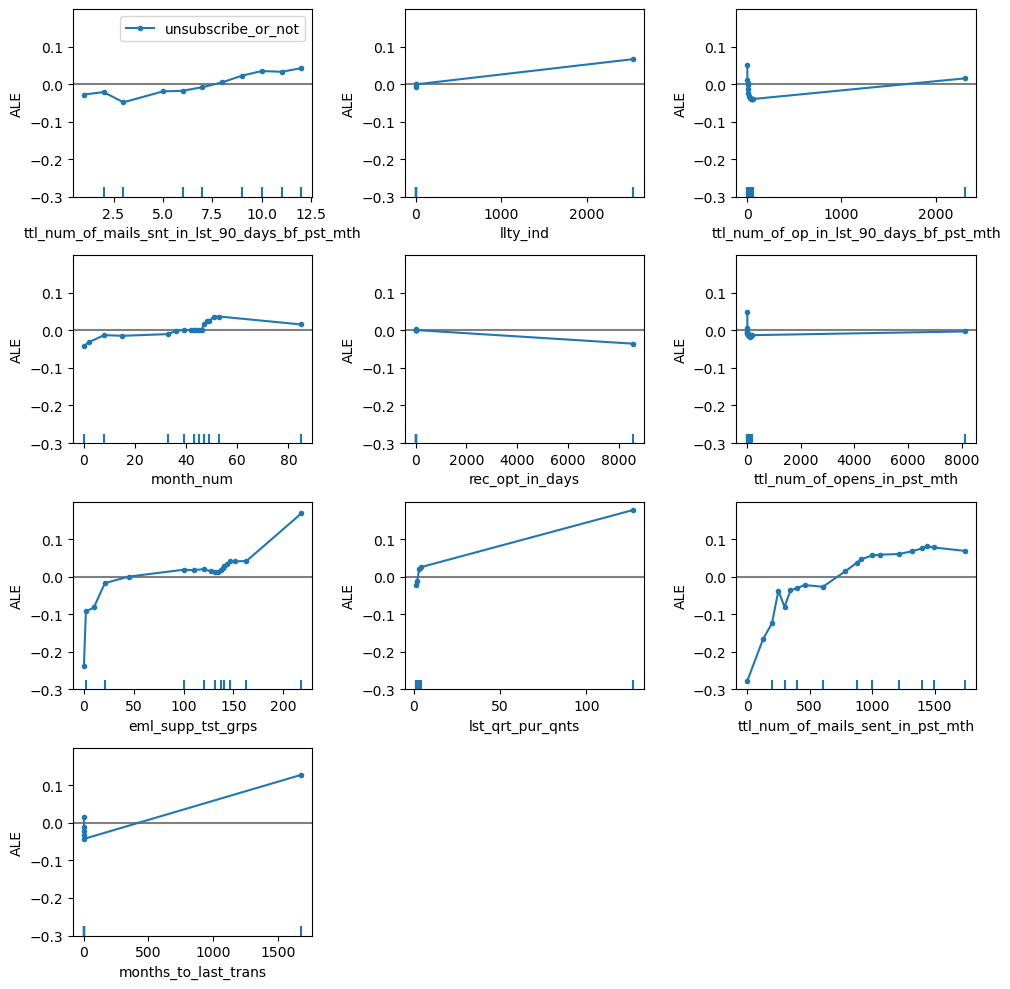

In [61]:
xgb1_exp = ale_plots(X_train_y, feature_names, target_names, xgbc1_y, num_for_slicing=100000)

In [22]:
del X_train_y
del y_train_y

### Testing on OOS data

In [21]:
# TESTING DATA OOS
t1 = time.time()

qr2 = '''SELECT * FROM kohls-bda-mkt-prd.dp_marketing_sandbox.TKA1JB1_email_unsubscribe_yearly_data_r3_test_OOS_1'''
testing_data = pandas_gbq.read_gbq(qr2,project_id='kohls-bda-mkt-lle',use_bqstorage_api=True)

print(f"Total time taken to read the data : {(time.time()-t1)/60} mins")

Downloading: 100%|██████████|
Total time taken to read the data : 1.8130104343096416 mins


In [23]:
for col in col_to_convert_float_ls:
    testing_data[col] = testing_data[col].astype(float)
testing_data["eml_supp_tst_grps"] = le.transform(testing_data["eml_supp_tst_grps"])

In [24]:
X_test_y = testing_data.drop(columns = ["email_addr", "vantage_date", "cust_id", "unsubscribe_or_not"], axis = 1)
y_test_y = testing_data['unsubscribe_or_not'].astype(int)
del testing_data

collected_objects = gc.collect()

In [29]:
X_test_y.shape, y_test_y.shape

((7943353, 74), (7943353,))

#### Testing on XGBC

In [25]:
gini_oos_y, lorenz_oos_y, data_oos_y = model_testing(X_test_y, y_test_y, xgbc_y)

Accuracy score : 0.9816931212801445, Precision score : 0.8607449856733524, Recall score : 0.010240187623144733, f1 score : 0.02023958712320276
Confusion matrix : [[7796433     243]
 [ 145175    1502]]


In [26]:
gini_oos_y

0.6230683823490375

In [27]:
lorenz_oos_y

,grp,y_pred_xgbc_y_oos,unsubscribe_or_not,num_mail_id,actual_not_unsubscribed,actual_unsubscribed,per_unsubscribed,y_pred_xgbc_oot_cum,unsubscribe_or_not_cum,num_mail_id_cum,actual_not_unsubscribed_cum,actual_unsubscribed_cum,per_unsubscribed_cum
0,1,0.211138,0.215474,79434,62318,17116,0.215474,0.211138,0.215474,79434,62318,17116,0.215474
1,3,0.115882,0.119119,158867,139943,18924,0.119119,0.147634,0.151237,238301,202261,36040,0.151237
2,5,0.078505,0.074836,158867,146978,11889,0.074836,0.119982,0.120677,397168,349239,47929,0.120677
3,10,0.057428,0.058265,397168,374027,23141,0.058265,0.088705,0.089471,794336,723266,71070,0.089471
4,20,0.032173,0.032052,794335,768875,25460,0.032052,0.060439,0.060761,1588671,1492141,96530,0.060761
5,100,0.007997,0.007891,6354682,6304535,50147,0.007891,0.018485,0.018465,7943353,7796676,146677,0.018465


In [28]:
data_oos_y

,unsubscribe_or_not,y_pred_xgbc_y_oos,rank,perc_grp,grp
3054219,1,0.938332,0,1,1
2028687,1,0.938332,1,1,1
3743088,1,0.938332,2,1,1
3542732,1,0.938332,3,1,1
1916367,1,0.938332,4,1,1
...,...,...,...,...,...
3834051,0,0.000062,7943348,100,100
253863,0,0.000058,7943349,100,100
604999,0,0.000057,7943350,100,100
3350580,0,0.000054,7943351,100,100


In [30]:
data_oos_y[data_oos_y["perc_grp"] <= 1]

,unsubscribe_or_not,y_pred_xgbc_y_oos,rank,perc_grp,grp
3054219,1,0.938332,0,1,1
2028687,1,0.938332,1,1,1
3743088,1,0.938332,2,1,1
3542732,1,0.938332,3,1,1
1916367,1,0.938332,4,1,1
...,...,...,...,...,...
6332754,0,0.163288,79429,1,1
4978040,0,0.163284,79430,1,1
4898214,0,0.163282,79431,1,1
5659100,0,0.163282,79432,1,1


In [31]:
data_oos_y[data_oos_y["perc_grp"] <= 1][data_oos_y[data_oos_y["perc_grp"] <= 1]["y_pred_xgbc_y_oos"]>=0.5][data_oos_y[data_oos_y["perc_grp"] <= 1][data_oos_y[data_oos_y["perc_grp"] <= 1]["y_pred_xgbc_y_oos"]>=0.5]["unsubscribe_or_not"]==1]

,unsubscribe_or_not,y_pred_xgbc_y_oos,rank,perc_grp,grp
3054219,1,0.938332,0,1,1
2028687,1,0.938332,1,1,1
3743088,1,0.938332,2,1,1
3542732,1,0.938332,3,1,1
1916367,1,0.938332,4,1,1
...,...,...,...,...,...
1238917,1,0.509820,1729,1,1
4848463,1,0.507905,1732,1,1
4680457,1,0.503564,1739,1,1
4064474,1,0.503274,1740,1,1


In [224]:
data_oos_y[data_oos_y["perc_grp"] <= 2][data_oos_y[data_oos_y["perc_grp"] <= 2]["y_pred_xgbc_y_oos"]>=0.5][data_oos_y[data_oos_y["perc_grp"] <= 2][data_oos_y[data_oos_y["perc_grp"] <= 2]["y_pred_xgbc_y_oos"]>=0.5]["unsubscribe_or_not"]==1]

,unsubscribe_or_not,y_pred_xgbc_y_oos,rank,perc_grp,grp
2837430,1,0.977919,0,1,1
956660,1,0.977919,1,1,1
1669113,1,0.977919,2,1,1
2169189,1,0.977919,3,1,1
2937545,1,0.977919,4,1,1
...,...,...,...,...,...
5184420,1,0.515116,1422,1,1
3059682,1,0.513041,1424,1,1
5033785,1,0.506301,1432,1,1
650944,1,0.501669,1435,1,1


In [81]:
del data_oos_y
del lorenz_oos_y
del gini_oos_y

#### Testing on XGBC with spw

In [32]:
gini_oos1_y, lorenz_oos1_y, data_oos1_y = model_testing(X_test_y, y_test_y, xgbc1_y)

Accuracy score : 0.7523394717570779, Precision score : 0.05223951810689913, Recall score : 0.7240535325920219, f1 score : 0.09744827057810419
Confusion matrix : [[5869896 1926780]
 [  40475  106202]]


In [33]:
gini_oos1_y

0.6250059668529178

In [34]:
lorenz_oos1_y

,grp,y_pred_xgbc_y_oos,unsubscribe_or_not,num_mail_id,actual_not_unsubscribed,actual_unsubscribed,per_unsubscribed,y_pred_xgbc_oot_cum,unsubscribe_or_not_cum,num_mail_id_cum,actual_not_unsubscribed_cum,actual_unsubscribed_cum,per_unsubscribed_cum
0,1,0.919668,0.210577,79434,62707,16727,0.210577,0.919668,0.210577,79434,62707,16727,0.210577
1,3,0.866195,0.119616,158867,139864,19003,0.119616,0.884019,0.149936,238301,202571,35730,0.149936
2,5,0.816116,0.075906,158867,146808,12059,0.075906,0.856858,0.120324,397168,349379,47789,0.120324
3,10,0.760662,0.058341,397168,373997,23171,0.058341,0.808760,0.089332,794336,723376,70960,0.089332
4,20,0.635592,0.032567,794335,768466,25869,0.032567,0.722176,0.060950,1588671,1491842,96829,0.060950
5,100,0.264176,0.007844,6354682,6304834,49848,0.007844,0.355776,0.018465,7943353,7796676,146677,0.018465


In [35]:
data_oos1_y

,unsubscribe_or_not,y_pred_xgbc_y_oos,rank,perc_grp,grp
6700056,1,0.992954,0,1,1
2752076,1,0.992151,1,1,1
875832,1,0.992151,2,1,1
1460436,1,0.992151,3,1,1
910551,1,0.992151,4,1,1
...,...,...,...,...,...
230456,0,0.000578,7943348,100,100
531547,0,0.000578,7943349,100,100
3350580,0,0.000551,7943350,100,100
96971,0,0.000392,7943351,100,100


In [46]:
data_oos1_y[data_oos1_y["perc_grp"] == 100]

,unsubscribe_or_not,y_pred_xgbc_y_oos,rank,perc_grp,grp
3615708,0,0.007857,7863920,100,100
3916302,0,0.007857,7863921,100,100
3039309,0,0.007857,7863922,100,100
3398417,0,0.007857,7863923,100,100
359199,0,0.007857,7863924,100,100
...,...,...,...,...,...
230456,0,0.000578,7943348,100,100
531547,0,0.000578,7943349,100,100
3350580,0,0.000551,7943350,100,100
96971,0,0.000392,7943351,100,100


In [53]:
num = 100
data_oos1_y[data_oos1_y["perc_grp"] <= num][data_oos1_y[data_oos1_y["perc_grp"] <= num]["y_pred_xgbc_y_oos"]>=0.5][data_oos1_y[data_oos1_y["perc_grp"] <= num][data_oos1_y[data_oos1_y["perc_grp"] <= num]["y_pred_xgbc_y_oos"]>=0.5]["unsubscribe_or_not"]==1]

,unsubscribe_or_not,y_pred_xgbc_y_oos,rank,perc_grp,grp
6700056,1,0.992954,0,1,1
2752076,1,0.992151,1,1,1
875832,1,0.992151,2,1,1
1460436,1,0.992151,3,1,1
910551,1,0.992151,4,1,1
...,...,...,...,...,...
2032396,1,0.500053,2032627,26,100
2213489,1,0.500041,2032686,26,100
2307709,1,0.500036,2032730,26,100
661664,1,0.500009,2032860,26,100


In [94]:
del data_oos1_y
del lorenz_oos1_y
del gini_oos1_y

In [95]:
del X_test_y
del y_test_y

### Testing on OOT data

#### Mar 23 DATA

In [102]:
t1 = time.time()
qr = '''SELECT * FROM kohls-bda-mkt-prd.dp_marketing_sandbox.TKA1JB1_email_unsubscribe_year_data_for_mar_r3_OTT'''
data_OOT= pandas_gbq.read_gbq(qr,project_id='kohls-bda-mkt-lle',use_bqstorage_api=True)
print(f"Total time taken to read the data : {(time.time()-t1)/60} mins")

Downloading: 100%|██████████|
Total time taken to read the data : 3.954098614056905 mins


In [103]:
data_OOT.shape

(5699684, 78)

In [104]:
for col in col_to_convert_float_ls:
    data_OOT[col] = data_OOT[col].astype(float)
data_OOT["eml_supp_tst_grps"] = le.transform(data_OOT["eml_supp_tst_grps"])

In [105]:
X_test_data_OOT = data_OOT.drop(columns = ["email_addr", "vantage_date", "cust_id", "unsubscribe_or_not"], axis = 1)
y_test_data_OOT = data_OOT['unsubscribe_or_not'].astype(int)
del data_OOT

In [106]:
collected_objects = gc.collect()

In [107]:
X_test_data_OOT.shape, y_test_data_OOT.shape

((5699684, 74), (5699684,))

##### Testing on XGBC

In [108]:
gini_oot_y, lorenz_oot_y, data_oot_y = model_testing(X_test_data_OOT, y_test_data_OOT, xgbc_y)

Accuracy score : 0.9966554286167444, Precision score : 0.0, Recall score : 0.0, f1 score : 0.0
Confusion matrix : [[5680621      57]
 [  19006       0]]


In [109]:
gini_oot_y

0.4961731411833914

In [110]:
lorenz_oot_y

,grp,y_pred_xgbc_y_oos,unsubscribe_or_not,num_mail_id,actual_not_unsubscribed,actual_unsubscribed,per_unsubscribed,y_pred_xgbc_oot_cum,unsubscribe_or_not_cum,num_mail_id_cum,actual_not_unsubscribed_cum,actual_unsubscribed_cum,per_unsubscribed_cum
0,1,0.163240,0.019685,56997,55875,1122,0.019685,0.163240,0.019685,56997,55875,1122,0.019685
1,3,0.097095,0.012044,113994,112621,1373,0.012044,0.119144,0.014591,170991,168496,2495,0.014591
2,5,0.074723,0.025896,113994,111042,2952,0.025896,0.101375,0.019113,284985,279538,5447,0.019113
3,10,0.062740,0.005709,284984,283357,1627,0.005709,0.082058,0.012411,569969,562895,7074,0.012411
4,20,0.042595,0.005551,569968,566804,3164,0.005551,0.062326,0.008981,1139937,1129699,10238,0.008981
5,100,0.011680,0.001923,4559747,4550979,8768,0.001923,0.021809,0.003335,5699684,5680678,19006,0.003335


In [111]:
data_oot_y[data_oot_y["perc_grp"] <= 1]

,unsubscribe_or_not,y_pred_xgbc_y_oos,rank,perc_grp,grp
3708771,0,0.754785,0,1,1
4227685,0,0.680419,1,1,1
3676729,0,0.680124,2,1,1
3106692,0,0.666362,3,1,1
4105324,0,0.656464,4,1,1
...,...,...,...,...,...
4201923,0,0.120865,56992,1,1
4594371,0,0.120864,56993,1,1
1983898,0,0.120864,56994,1,1
4813070,0,0.120864,56995,1,1


In [116]:
data_oot_y[data_oot_y["perc_grp"] <= 1][data_oot_y[data_oot_y["perc_grp"] <= 1]["y_pred_xgbc_y_oos"]>=0.5][data_oot_y[data_oot_y["perc_grp"] <= 1][data_oot_y[data_oot_y["perc_grp"] <= 1]["y_pred_xgbc_y_oos"]>=0.5]["unsubscribe_or_not"]==1]

,unsubscribe_or_not,y_pred_xgbc_y_oos,rank,perc_grp,grp


##### Testing on XGBC with spw

In [117]:
gini_oot1_y, lorenz_oot1_y, data_oot1_y = model_testing(X_test_data_OOT, y_test_data_OOT, xgbc1_y)

Accuracy score : 0.6178444278665274, Precision score : 0.006449285764574325, Recall score : 0.7422392928548879, f1 score : 0.012787461815281138
Confusion matrix : [[3507411 2173267]
 [   4899   14107]]


In [118]:
gini_oot1_y

0.5047533663924273

In [119]:
lorenz_oot1_y

,grp,y_pred_xgbc_y_oos,unsubscribe_or_not,num_mail_id,actual_not_unsubscribed,actual_unsubscribed,per_unsubscribed,y_pred_xgbc_oot_cum,unsubscribe_or_not_cum,num_mail_id_cum,actual_not_unsubscribed_cum,actual_unsubscribed_cum,per_unsubscribed_cum
0,1,0.895711,0.022791,56997,55698,1299,0.022791,0.895711,0.022791,56997,55698,1299,0.022791
1,3,0.839722,0.012764,113994,112539,1455,0.012764,0.858385,0.016106,170991,168237,2754,0.016106
2,5,0.804842,0.025773,113994,111056,2938,0.025773,0.836968,0.019973,284985,279293,5692,0.019973
3,10,0.764603,0.007137,284984,282950,2034,0.007137,0.800786,0.013555,569969,562243,7726,0.013555
4,20,0.700821,0.004707,569968,567285,2683,0.004707,0.750803,0.009131,1139937,1129528,10409,0.009131
5,100,0.348771,0.001885,4559747,4551150,8597,0.001885,0.429177,0.003335,5699684,5680678,19006,0.003335


In [126]:
data_oot1_y

,unsubscribe_or_not,y_pred_xgbc1_y_oot,rank,perc_grp,grp
89874,0,0.999740,0,1,1
3091825,0,0.999670,1,1,1
70989,0,0.999644,2,1,1
3004268,1,0.999602,3,1,1
3068517,0,0.999568,4,1,1
...,...,...,...,...,...
2706876,0,0.000769,6393997,100,100
547124,0,0.000769,6393998,100,100
1161366,0,0.000769,6393999,100,100
1711394,0,0.000565,6394000,100,100


In [130]:
data_oot1_y[data_oot1_y["perc_grp"] == 100]

,unsubscribe_or_not,y_pred_xgbc_y_oos,rank,perc_grp,grp
1006273,0,0.010389,5642688,100,100
677175,0,0.010389,5642689,100,100
2186048,0,0.010389,5642690,100,100
1837380,0,0.010389,5642691,100,100
2137803,0,0.010389,5642692,100,100
...,...,...,...,...,...
148405,0,0.001159,5699679,100,100
189113,0,0.001099,5699680,100,100
4609,0,0.001053,5699681,100,100
79977,0,0.000812,5699682,100,100


In [137]:
num = 100
data_oot1_y[data_oot1_y["perc_grp"] <= num][data_oot1_y[data_oot1_y["perc_grp"] <= num]["y_pred_xgbc_y_oos"]>=0.5][data_oot1_y[data_oot1_y["perc_grp"] <= num][data_oot1_y[data_oot1_y["perc_grp"] <= num]["y_pred_xgbc_y_oos"]>=0.5]["unsubscribe_or_not"]==1]

,unsubscribe_or_not,y_pred_xgbc_y_oos,rank,perc_grp,grp
3400861,1,0.980819,5,1,1
4786112,1,0.977087,20,1,1
3542856,1,0.976768,22,1,1
4261165,1,0.975444,30,1,1
3667992,1,0.975251,32,1,1
...,...,...,...,...,...
4784489,1,0.500168,2186158,39,100
2808444,1,0.500143,2186287,39,100
3433658,1,0.500050,2187051,39,100
4597262,1,0.500029,2187156,39,100


In [249]:
del data_oos_y
del lorenz_oos_y
del gini_oos_y

del data_oos1_y
del lorenz_oos1_y
del gini_oos1_y

#### FEB 23 DATA

In [296]:
t1 = time.time()
qr = '''SELECT * FROM kohls-bda-mkt-prd.dp_marketing_sandbox.TKA1JB1_email_unsubscribe_year_data_for_feb_r2_OTT'''
data_OOT= pandas_gbq.read_gbq(qr,project_id='kohls-bda-mkt-lle',use_bqstorage_api=True)
print(f"Total time taken to read the data : {(time.time()-t1)/60} mins")

Downloading: 100%|██████████|
Total time taken to read the data : 1.1888744870821635 mins


In [297]:
data_OOT.shape

(5828873, 78)

In [298]:
for col in col_to_convert_float_ls:
    data_OOT[col] = data_OOT[col].astype(float)
data_OOT["eml_supp_tst_grps"] = le.transform(data_OOT["eml_supp_tst_grps"])

In [299]:
data_OOT.head()

,email_addr,vantage_date,month_num,unsubscribe_or_not,ttl_num_of_cls_in_pst_mth,ttl_num_of_opens_in_pst_mth,ttl_num_of_mails_sent_in_pst_mth,ttl_num_of_cls_in_lst_90_days_bf_pst_mth,ttl_num_of_op_in_lst_90_days_bf_pst_mth,ttl_num_of_mails_snt_in_lst_90_days_bf_pst_mth,cust_id,ttl_opt_out_num,rec_opt_in_days,mail_cnt_asn_pr_cust,total_trip_cnt,months_to_last_trans,cust_age,med_incm,kc_holder,dist_to_store,lst_qrt_trp_cnt,lst_qrt_pur_qnts,lst_qrt_spt_amt,lst_qrt_dis_qnt,lst_qrt_dis_spt_amt,lst_qrt_pur_qnts_wt_kc_card,lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_lst_qrt,BEAUTY_trans_pur_amt_for_lst_qrt,CHILDRENS_trans_pur_amt_for_lst_qrt,HOME_trans_pur_amt_for_lst_qrt,MENS_trans_pur_amt_for_lst_qrt,WOMENS_trans_pur_amt_for_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_lst_qrt,sec_lst_qrt_trp_cnt,sec_lst_qrt_pur_qnts,sec_lst_qrt_spt_amt,sec_lst_qrt_dis_qnt,sec_lst_qrt_dis_spt_amt,sec_lst_qrt_pur_qnts_wt_kc_card,sec_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_sec_lst_qrt,BEAUTY_trans_pur_amt_for_sec_lst_qrt,CHILDRENS_trans_pur_amt_for_sec_lst_qrt,HOME_trans_pur_amt_for_sec_lst_qrt,MENS_trans_pur_amt_for_sec_lst_qrt,WOMENS_trans_pur_amt_for_sec_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_sec_lst_qrt,trd_lst_qrt_trp_cnt,trd_lst_qrt_pur_qnts,trd_lst_qrt_spt_amt,trd_lst_qrt_dis_qnt,trd_lst_qrt_dis_spt_amt,trd_lst_qrt_pur_qnts_wt_kc_card,trd_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_trd_lst_qrt,BEAUTY_trans_pur_amt_for_trd_lst_qrt,CHILDRENS_trans_pur_amt_for_trd_lst_qrt,HOME_trans_pur_amt_for_trd_lst_qrt,MENS_trans_pur_amt_for_trd_lst_qrt,WOMENS_trans_pur_amt_for_trd_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_trd_lst_qrt,frt_lst_qrt_trp_cnt,frt_lst_qrt_pur_qnts,frt_lst_qrt_spt_amt,frt_lst_qrt_dis_qnt,frt_lst_qrt_dis_spt_amt,frt_lst_qrt_pur_qnts_wt_kc_card,frt_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_frt_lst_qrt,BEAUTY_trans_pur_amt_for_frt_lst_qrt,CHILDRENS_trans_pur_amt_for_frt_lst_qrt,HOME_trans_pur_amt_for_frt_lst_qrt,MENS_trans_pur_amt_for_frt_lst_qrt,WOMENS_trans_pur_amt_for_frt_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_frt_lst_qrt,llty_ind,eml_supp_tst_grps
0,gT66vnH5uTNx@kupgD.PGv,2023-02-01,2,0,0,0,33,0,0,100,105593427,<NA>,481,2,255,0,52,87500,1,3.626592,12,29,353.98,29,353.98,29,353.98,0.00,0.00,0.0,232.17,0.0,0.00,0.0,6,8,52.87,7,52.87,7,52.87,0.00,0.00,0.0,4.19,0.0,36.37,0.0,7,19,231.78,16,175.19,19,231.78,31.60,0.00,0.0,20.95,0.0,118.24,0.0,2,4,61.83,3,36.84,4,61.83,0.00,0.00,0.00,0.84,0.00,0.00,0.00,1,2
1,fOwHEf8d5W5fQjw@fBj8k.QLv,2023-02-01,2,0,0,51,46,0,193,188,8623480,<NA>,1227,2,190,1,34,87500,0,0.766901,13,68,831.26,39,448.55,0,0.00,39.06,111.00,0.0,361.77,0.0,57.88,0.0,12,60,885.51,32,445.71,0,0.00,35.00,11.00,0.0,200.35,0.0,271.86,0.0,6,21,497.88,13,365.68,0,0.00,0.00,0.00,0.0,138.18,0.0,109.12,0.0,7,18,605.58,9,425.62,0,0.00,24.99,0.00,0.00,302.90,0.00,0.00,72.74,1,2
2,MqfYFimQo@Pg4Sd.iDD,2023-02-01,2,0,0,0,47,0,13,176,11040091,2,1554,1,395,1,64,22500,1,1.605811,13,48,564.47,41,430.33,46,502.47,34.05,62.00,0.0,94.60,0.0,122.89,0.0,12,35,474.90,34,447.49,35,474.90,54.99,0.00,0.0,0.00,0.0,201.95,0.0,13,34,539.00,30,479.54,33,539.00,70.76,0.00,0.0,9.48,0.0,319.88,0.0,9,35,646.65,31,320.63,28,609.65,116.08,0.00,0.00,0.00,54.92,128.86,14.29,1,2
3,rGM3ZyRBMH@2XEFAIa.5ui,2023-02-01,2,0,0,0,8,0,0,45,34815629,<NA>,<NA>,1,179,1,40,87500,1,2.748787,17,181,2098.35,87,664.75,53,572.54,129.35,635.66,0.0,617.74,0.0,283.21,0.0,25,208,2506.11,122,905.60,38,350.74,138.40,1102.98,0.0,207.85,0.0,432.91,0.0,19,114,1576.41,49,629.87,40,653.43,19.14,789.53,0.0,201.17,0.0,163.58,0.0,26,140,1912.97,102,1162.37,84,1269.29,246.35,16.41,248.66,348.70,55.42,310.09,103.24,1,2
4,pF7rHG@oCoa94j5.0P8,2023-02-01,2,0,0,0,8,0,0,45,141379655,<NA>,<NA>,4,347,0,57,<NA>,1,4.161542,15,107,1972.66,79,998.05,82,1311.35,780.80,0.00,0.0,148.16,0.0,303.60,0.0,8,69,575.82,61,417.18,69,575.82,123.36,0.00,0.0,44.72,0.0,138.23,0.0,5,30,734.03,17,349.95,24,568.58,50.16,0.00,0.0,64.97,0.0,74.38,0.0,5,30,363.46,28,324.68,30,363.46,171.80,0.00,0.00,73

In [300]:
X_test_data_OOT = data_OOT.drop(columns = ["email_addr", "vantage_date", "cust_id", "unsubscribe_or_not"], axis = 1)
y_test_data_OOT = data_OOT['unsubscribe_or_not'].astype(int)
del data_OOT

In [301]:
collected_objects = gc.collect()

In [302]:
X_test_data_OOT.shape, y_test_data_OOT.shape

((5828873, 74), (5828873,))

##### Testing on XGBC

In [303]:
gini_oot_y, lorenz_oot_y, data_oot_y = model_testing(X_test_data_OOT, y_test_data_OOT, xgbc_y)

Accuracy score : 0.9913542463525968, Precision score : 0.25, Recall score : 1.9844025955985952e-05, f1 score : 3.9684901879080106e-05
Confusion matrix : [[5778477       3]
 [  50392       1]]


In [304]:
gini_oot_y

0.3947203993515076

In [305]:
lorenz_oot_y

,grp,y_pred_xgbc_y_oos,unsubscribe_or_not,num_mail_id,actual_not_unsubscribed,actual_unsubscribed,per_unsubscribed,y_pred_xgbc_oot_cum,unsubscribe_or_not_cum,num_mail_id_cum,actual_not_unsubscribed_cum,actual_unsubscribed_cum,per_unsubscribed_cum
0,1,0.165847,0.018117,58289,57233,1056,0.018117,0.165847,0.018117,58289,57233,1056,0.018117
1,3,0.102688,0.018425,116578,114430,2148,0.018425,0.123741,0.018322,174867,171663,3204,0.018322
2,5,0.066311,0.028273,116577,113281,3296,0.028273,0.100769,0.022303,291444,284944,6500,0.022303
3,10,0.047746,0.026362,291444,283761,7683,0.026362,0.074257,0.024332,582888,568705,14183,0.024332
4,20,0.024105,0.015804,582887,573675,9212,0.015804,0.049181,0.020068,1165775,1142380,23395,0.020068
5,100,0.006553,0.005790,4663098,4636100,26998,0.005790,0.015079,0.008645,5828873,5778480,50393,0.008645


In [306]:
data_oot_y

,unsubscribe_or_not,y_pred_xgbc_y_oos,rank,perc_grp,grp
5456986,0,0.678230,0,1,1
47782,1,0.619463,1,1,1
5809601,0,0.517569,2,1,1
3812176,0,0.513608,3,1,1
34881,0,0.492462,4,1,1
...,...,...,...,...,...
1898033,0,0.000036,5828868,100,100
53615,0,0.000036,5828869,100,100
1206509,0,0.000036,5828870,100,100
1782304,0,0.000036,5828871,100,100


In [307]:
data_oot_y[data_oot_y["perc_grp"] == 1]

,unsubscribe_or_not,y_pred_xgbc_y_oos,rank,perc_grp,grp
5456986,0,0.678230,0,1,1
47782,1,0.619463,1,1,1
5809601,0,0.517569,2,1,1
3812176,0,0.513608,3,1,1
34881,0,0.492462,4,1,1
...,...,...,...,...,...
3793679,1,0.120534,58284,1,1
3156985,0,0.120529,58285,1,1
3360486,0,0.120528,58286,1,1
5130824,0,0.120522,58287,1,1


In [308]:
data_oot_y[data_oot_y["perc_grp"] <= 1][data_oot_y[data_oot_y["perc_grp"] <= 1]["y_pred_xgbc_y_oos"]>=0.5][data_oot_y[data_oot_y["perc_grp"] <= 1][data_oot_y[data_oot_y["perc_grp"] <= 1]["y_pred_xgbc_y_oos"]>=0.5]["unsubscribe_or_not"]==1]

,unsubscribe_or_not,y_pred_xgbc_y_oos,rank,perc_grp,grp
47782,1,0.619463,1,1,1


##### Testing on XGBC with spw

In [309]:
gini_oot1_y, lorenz_oot1_y, data_oot1_y = model_testing(X_test_data_OOT, y_test_data_OOT, xgbc1_y)

Accuracy score : 0.7725306418582117, Precision score : 0.019083621205163066, Recall score : 0.5021927648681365, f1 score : 0.03676996216502095
Confusion matrix : [[4477676 1300804]
 [  25086   25307]]


In [310]:
gini_oot1_y

0.39797301754402387

In [311]:
lorenz_oot1_y

,grp,y_pred_xgbc_y_oos,unsubscribe_or_not,num_mail_id,actual_not_unsubscribed,actual_unsubscribed,per_unsubscribed,y_pred_xgbc_oot_cum,unsubscribe_or_not_cum,num_mail_id_cum,actual_not_unsubscribed_cum,actual_unsubscribed_cum,per_unsubscribed_cum
0,1,0.899595,0.017225,58289,57285,1004,0.017225,0.899595,0.017225,58289,57285,1004,0.017225
1,3,0.861561,0.018468,116578,114425,2153,0.018468,0.874239,0.018054,174867,171710,3157,0.018054
2,5,0.807570,0.027493,116577,113372,3205,0.027493,0.847571,0.021829,291444,285082,6362,0.021829
3,10,0.733563,0.028239,291444,283214,8230,0.028239,0.790567,0.025034,582888,568296,14592,0.025034
4,20,0.590553,0.015101,582887,574085,8802,0.015101,0.690560,0.020067,1165775,1142381,23394,0.020067
5,100,0.241287,0.005790,4663098,4636099,26999,0.005790,0.331142,0.008645,5828873,5778480,50393,0.008645


In [312]:
data_oot1_y

,unsubscribe_or_not,y_pred_xgbc_y_oos,rank,perc_grp,grp
5184170,0,0.995602,0,1,1
113253,0,0.993240,1,1,1
5828341,0,0.993141,2,1,1
4599839,0,0.992200,3,1,1
5510684,0,0.990804,4,1,1
...,...,...,...,...,...
1007761,0,0.000565,5828868,100,100
1620188,0,0.000565,5828869,100,100
1689008,0,0.000565,5828870,100,100
2304988,0,0.000560,5828871,100,100


In [313]:
data_oot1_y[data_oot1_y["perc_grp"] == 100]

,unsubscribe_or_not,y_pred_xgbc_y_oos,rank,perc_grp,grp
938611,0,0.004355,5770585,100,100
1907482,0,0.004355,5770586,100,100
724321,0,0.004355,5770587,100,100
497252,0,0.004355,5770588,100,100
392799,0,0.004355,5770589,100,100
...,...,...,...,...,...
1007761,0,0.000565,5828868,100,100
1620188,0,0.000565,5828869,100,100
1689008,0,0.000565,5828870,100,100
2304988,0,0.000560,5828871,100,100


In [314]:
num = 100
data_oot1_y[data_oot1_y["perc_grp"] <= num][data_oot1_y[data_oot1_y["perc_grp"] <= num]["y_pred_xgbc_y_oos"]>=0.5][data_oot1_y[data_oot1_y["perc_grp"] <= num][data_oot1_y[data_oot1_y["perc_grp"] <= num]["y_pred_xgbc_y_oos"]>=0.5]["unsubscribe_or_not"]==1]

,unsubscribe_or_not,y_pred_xgbc_y_oos,rank,perc_grp,grp
5159420,1,0.985911,10,1,1
4235684,1,0.974151,57,1,1
47782,1,0.972872,64,1,1
5133074,1,0.966599,106,1,1
3024620,1,0.966239,108,1,1
...,...,...,...,...,...
2523483,1,0.500109,1325668,23,100
3718631,1,0.500068,1325825,23,100
3444175,1,0.500057,1325921,23,100
3680678,1,0.500037,1325990,23,100


In [315]:
# del data_oos_y
# del lorenz_oos_y
# del gini_oos_y

# del data_oos1_y
# del lorenz_oos1_y
# del gini_oos1_y

In [316]:
data_oot1_y[data_oot1_y["perc_grp"] == 1]

,unsubscribe_or_not,y_pred_xgbc_y_oos,rank,perc_grp,grp
5184170,0,0.995602,0,1,1
113253,0,0.993240,1,1,1
5828341,0,0.993141,2,1,1
4599839,0,0.992200,3,1,1
5510684,0,0.990804,4,1,1
...,...,...,...,...,...
1690267,0,0.879992,58284,1,1
1441965,0,0.879992,58285,1,1
2783814,0,0.879992,58286,1,1
2783818,0,0.879992,58287,1,1


In [320]:
# X_test_data_OOT.columns